In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install mlxtend

Note: you may need to restart the kernel to use updated packages.


In [55]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [3]:
#Import the required libraries
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from matplotlib.colors import ListedColormap
from sklearn import tree

In [4]:
#Global Parameters
main_result_dict = {"Feature Size":[], "Logistic Regression":[], "Decision Trees":[], 
                    "Random Forest":[], "K-Neatest Neighbors":[], 
                    "Support Vector Machines":[], "XGBoost":[]}
feature_size_list = []

In [5]:
#Define model parameters
log_reg_params = [{"C":1, "max_iter":1000}]
# dec_tree_params = [{"max_depth":1}, {"criterion": "gini"}, {"criterion": "entropy"}]
dec_tree_params = [{"criterion": "gini"}]
rand_for_params = [{"criterion": "gini"}]
kneighbors_params = [{"n_neighbors":20}]
# naive_bayes_params = [{}]
# svc_params = [{"C":0.01, "kernel": "rbf", "probability":True}, {"C":0.1, "kernel": "rbf", "probability":True}, {"C":1, "kernel": "rbf", "probability":True}, {"C":10, "kernel": "rbf", "probability":True}]
svc_params = [{"C":10, "kernel": "rbf", "probability":True}]
# adb_params = [{}]
xgb_params = [{}]

In [6]:
#All the models to be tested
# modelclasses = [
#     ["Logistic Regression", LogisticRegression, log_reg_params],
#     ["Decision Trees", DecisionTreeClassifier, dec_tree_params],
#     ["Random Forest", RandomForestClassifier, rand_for_params],
#     ["K-Neatest Neighbors", KNeighborsClassifier, kneighbors_params],
#     ["Gaussian Naive Bayes", GaussianNB, naive_bayes_params],
#     ["Support Vector Machines", SVC, svc_params],
#     ['AdaBoost', AdaBoostClassifier, adb_params],
#     ['XGBoost', XGBClassifier, xgb_params]
# ]
modelclasses = [
    ["Logistic Regression", LogisticRegression, log_reg_params],
    ["Decision Trees", DecisionTreeClassifier, dec_tree_params],
    ["Random Forest", RandomForestClassifier, rand_for_params],
    ["K-Neatest Neighbors", KNeighborsClassifier, kneighbors_params],
    ["Support Vector Machines", SVC, svc_params],
    ["XGBoost", XGBClassifier, xgb_params]
]

In [7]:
#Pre-process the dataset
def makeScaller(x_train, y_train, x_test, y_test):
    sc = MinMaxScaler()
    le = LabelEncoder()
    
    #Scale the feature columns
    x_train = sc.fit_transform(x_train)
    x_test = sc.transform(x_test)

    #Label encode the target columns
    y_train = le.fit_transform(y_train)
    y_test = le.fit_transform(y_test)
    
    return x_train, y_train, x_test, y_test

In [8]:
#Function the fits different models and then append various train & test data into result list
def train_models(x_train, y_train, x_test, y_test, target_names, feature_method="No feature selection"):
    results = []
    feature_size_list.append("{}".format(feature_method))
    main_result_dict["Feature Size"].append(x_train.shape[1])
    for modelname, Model, params_list in modelclasses:
        for params in params_list:
            #Train the model
            model = Model(**params)
            model.fit(x_train, y_train)

            #Cross validation score (10-fold)
            cross_val = cross_val_score(estimator = model, X = x_train, y = y_train, cv = 10).mean()

            #Training accuracy
            y_pred_train = model.predict(x_train)
            accuracy_train = accuracy_score(y_train, y_pred_train)

            #Testing accuracy
            y_pred_test = model.predict(x_test)
            accuracy_test = accuracy_score(y_test, y_pred_test)

            #Confusion matrix
            confusion_mat = confusion_matrix(y_test, y_pred_test, labels=[1, 0])

            #Classification report
            report = classification_report(y_test, y_pred_test, target_names=target_names)

            #For roc-auc curve
            yproba = model.predict_proba(x_test)[::, 1]
            fpr, tpr, _ = roc_curve(y_test,  yproba)
            auc = roc_auc_score(y_test, yproba)

            #store results in 2-D array
            results.append((modelname, model, params, accuracy_train, 
                            accuracy_test, cross_val, confusion_mat, 
                            report, fpr, tpr, auc))
            
    #Return the stored results
    return results

In [9]:
#Summarize the results from the trained models
def model_summary(results):
    
    #sort the results in descending order as per the 10-fold cross validation score
    results.sort(key=lambda x:x[-6], reverse=True)
    
    #print the data
    for modelname, model, params, accuracy_train, accuracy_test, cross_val, confusion_mat, report, _, _, auc in results:
        print("Model Name : {}\nParameters : {}\nTraining Accuracy : {:.2f}%\nTesting Accuracy : {:.2f}%\nCross Validation : {:.2f}%\nConfusion Matrix : \n\nClassification Report: -\n{}\n\n".format(modelname, params, accuracy_train*100, accuracy_test*100, cross_val*100, confusion_mat,report))
        main_result_dict[modelname].append("{:.2f}% | {:.2f}% | {:.3f}".format(accuracy_train*100, cross_val*100, auc))

In [10]:
#Plot the auc-roc curve for all
def plot_auc_roc(results):
    fig = plt.figure(figsize=(15,10))
    results.sort(key=lambda x:x[-1], reverse=True)
    for modelname,_,_,_,_,_,_,_,fpr,tpr,auc in results:
        plt.plot(fpr, tpr, label="{}, AUC={:.3f}".format(modelname, auc))

    plt.plot([0,1], [0,1], color='orange', linestyle='--')

    plt.xticks(np.arange(0.0, 1.1, step=0.1))
    plt.xlabel("False Positivity Rate", fontsize=15)

    plt.yticks(np.arange(0.0, 1.1, step=0.1))
    plt.ylabel("True Positivity Rate", fontsize=15)

    plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
    plt.legend(prop={'size':13}, loc='lower right')

    plt.show()

In [11]:
#Train the model & test in on all/best features
def all_function_call(x_train, y_train, x_test, y_test, feature_method="No feature selection"):
    
    print("\n<<<Executing all ML models for {} features>>>\n".format(x_train.shape[1]))

    #Call function to scale the features
    xtrain, ytrain, xtest, ytest = makeScaller(x_train, y_train, x_test, y_test)
    
    #Call function to train the models
    result = []
    target_names = ['Control', 'Ts65Dn']
    result = train_models(xtrain, ytrain, xtest, ytest, target_names, feature_method)

    #Call function to print model_summary
    model_summary(result)
    
    if feature_method == "10 Best Features":
        plot_auc_roc(result)
    
    print("\nFeature size list : ", feature_size_list)
    print("\nMain result dict : ", main_result_dict)

In [12]:
#Forward feature selection
def forward_feature_selection(x_train, y_train, total_features):
    feature_selection = sfs(RandomForestClassifier(n_jobs=-1),
                                    k_features=(1, total_features),
                                    forward=True,
                                    floating=False,
                                    verbose=2,
                                    scoring='accuracy',
                                    cv=10).fit(x_train, y_train)

    best_features = [x for x in feature_selection.k_feature_names_]
    print("Best features <out of 12> : ", len(best_features))
    print("Best feature names : ", best_features)
    print("Best features score : ", feature_selection.k_score_)
    return best_features

In [13]:
#Import the datasets
data = pd.read_csv("./Data_Cortex_Nuclear.csv")

In [14]:
#Raw representation of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MouseID          1080 non-null   object 
 1   DYRK1A_N         1077 non-null   float64
 2   ITSN1_N          1077 non-null   float64
 3   BDNF_N           1077 non-null   float64
 4   NR1_N            1077 non-null   float64
 5   NR2A_N           1077 non-null   float64
 6   pAKT_N           1077 non-null   float64
 7   pBRAF_N          1077 non-null   float64
 8   pCAMKII_N        1077 non-null   float64
 9   pCREB_N          1077 non-null   float64
 10  pELK_N           1077 non-null   float64
 11  pERK_N           1077 non-null   float64
 12  pJNK_N           1077 non-null   float64
 13  PKCA_N           1077 non-null   float64
 14  pMEK_N           1077 non-null   float64
 15  pNR1_N           1077 non-null   float64
 16  pNR2A_N          1077 non-null   float64
 17  pNR2B_N       

In [15]:
#First 5 rows of the datatset
data.head()

,MouseID,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,...,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
0,309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,...,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m
1,309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,...,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m
2,309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,...,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m
3,309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,...,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m
4,309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,...,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730,Control,Memantine,C/S,c-CS-m


In [16]:
#--------------------------------------------Dataset Pre-processing------------------------------------------------

In [17]:
#Unique classes of mice
'''c-CS-s: control mice, stimulated to learn, injected with saline (9 mice)
c-CS-m: control mice, stimulated to learn, injected with memantine (10 mice)
c-SC-s: control mice, not stimulated to learn, injected with saline (9 mice)
c-SC-m: control mice, not stimulated to learn, injected with memantine (10 mice)
t-CS-s: trisomy mice, stimulated to learn, injected with saline (7 mice)
t-CS-m: trisomy mice, stimulated to learn, injected with memantine (9 mice)
t-SC-s: trisomy mice, not stimulated to learn, injected with saline (9 mice)
t-SC-m: trisomy mice, not stimulated to learn, injected with memantine (9 mice)'''
print("Unique values in column Class : ", data["class"].unique())
print("Unique values in column MouseID : ", data["MouseID"].unique())
print("Unique values in column Genotype : ", data["Genotype"].unique())
print("Unique values in column Treatment : ", data["Treatment"].unique())
print("Unique values in column Behavior : ", data["Behavior"].unique())

Unique values in column Class :  ['c-CS-m' 'c-SC-m' 'c-CS-s' 'c-SC-s' 't-CS-m' 't-SC-m' 't-CS-s' 't-SC-s']
Unique values in column MouseID :  ['309_1' '309_2' '309_3' ... 'J3295_13' 'J3295_14' 'J3295_15']
Unique values in column Genotype :  ['Control' 'Ts65Dn']
Unique values in column Treatment :  ['Memantine' 'Saline']
Unique values in column Behavior :  ['C/S' 'S/C']


In [18]:
#Convert the above categorical variables into numeric data
#Dropping the MouseID column, cause it is not needed
#Converting Genotype unique values into 0 --> Control & 1 --> Ts65Dn
#Converting Treatment unique values into 10 --> Memantine & 11 --> Saline
#Converting Behavior unique values into 5 --> C/S & 6 --> S/C
data = data.drop('MouseID', axis = 1)
data = data.drop('class', axis = 1)
data = data.drop('Treatment', axis = 1)
data = data.drop('Behavior', axis = 1)
data['Genotype'].replace(['Control', 'Ts65Dn'], [0, 1], inplace=True)
# data['Treatment'].replace(['Memantine', 'Saline'], [10, 11], inplace=True)
# data['Behavior'].replace(['C/S', 'S/C'], [5, 6], inplace=True)
# target_names = ['c-CS-m', 'c-SC-m', 'c-CS-s', 'c-SC-s', 't-CS-m', 't-SC-m', 't-CS-s', 't-SC-s']
# data['class'].replace(target_names, [1, 2, 3, 4, 5, 6, 7, 8], inplace=True)

Number of columns having null values :  49


<AxesSubplot:>

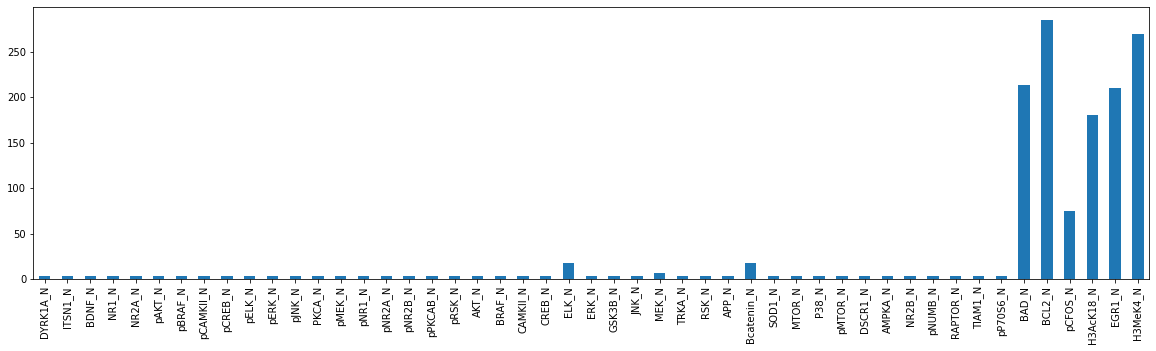

In [19]:
#Null data in the dataset
print("Number of columns having null values : ", len(data.isna().sum()[data.isna().sum()>0]))
data.isna().sum()[data.isna().sum()>0].plot(kind='bar', figsize=(20, 5))

In [20]:
#Delete rows having majority of the data as Null
data = data.dropna(axis=0, subset=['ITSN1_N'])

Number of columns having null values now :  9


<AxesSubplot:>

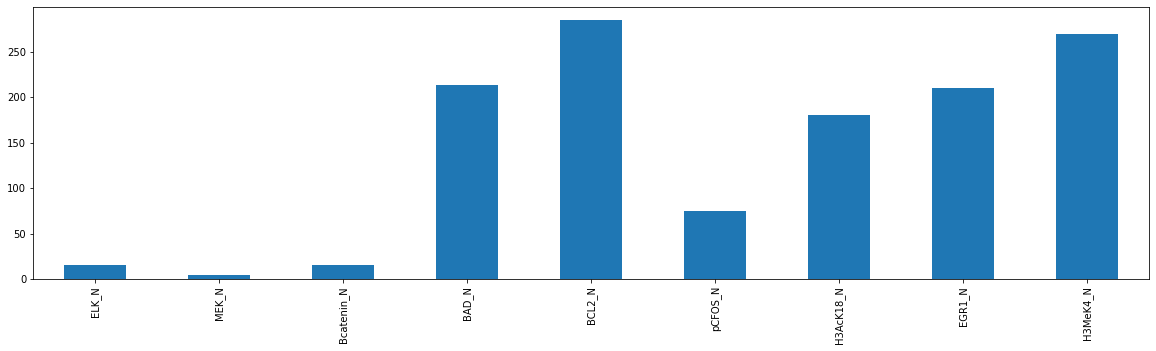

In [21]:
#Null data in the dataset
'''We can see that deleting the rows that have majority of the data as Null, 
reduces the number of null columns from 49 to 9
'''
print("Number of columns having null values now : ", len(data.isna().sum()[data.isna().sum()>0]))
data.isna().sum()[data.isna().sum()>0].plot(kind='bar', figsize=(20, 5))

In [22]:
#Fill the null values using SimpleImputer, scikit-learn's method that can replace the NaN values with mean values.
columns = data.columns
imputer = SimpleImputer(missing_values = np.nan, strategy ='mean')
imputer = imputer.fit(data)
data = imputer.transform(data)
data = pd.DataFrame(data)
data.columns = columns

In [23]:
print("Number of columns having null values now : ", len(data.isna().sum()[data.isna().sum()>0]))

Number of columns having null values now :  0


In [24]:
#First 5 rows of the datatset after pre-processing
data.head()

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,BAD_N,BCL2_N,pS6_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype
0,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,1.750936,...,0.122652,0.134757,0.106305,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,0.0
1,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,1.596377,...,0.116682,0.134757,0.106592,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,0.0
2,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,1.561316,...,0.118508,0.134757,0.108303,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,0.0
3,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,1.595086,...,0.132781,0.134757,0.103184,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,0.0
4,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,1.504230,...,0.129954,0.134757,0.104784,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730,0.0


In [25]:
#Raw representation of the dataset after pre-processing
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1077 entries, 0 to 1076
Data columns (total 78 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DYRK1A_N         1077 non-null   float64
 1   ITSN1_N          1077 non-null   float64
 2   BDNF_N           1077 non-null   float64
 3   NR1_N            1077 non-null   float64
 4   NR2A_N           1077 non-null   float64
 5   pAKT_N           1077 non-null   float64
 6   pBRAF_N          1077 non-null   float64
 7   pCAMKII_N        1077 non-null   float64
 8   pCREB_N          1077 non-null   float64
 9   pELK_N           1077 non-null   float64
 10  pERK_N           1077 non-null   float64
 11  pJNK_N           1077 non-null   float64
 12  PKCA_N           1077 non-null   float64
 13  pMEK_N           1077 non-null   float64
 14  pNR1_N           1077 non-null   float64
 15  pNR2A_N          1077 non-null   float64
 16  pNR2B_N          1077 non-null   float64
 17  pPKCAB_N      

In [26]:
data.describe()

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,BAD_N,BCL2_N,pS6_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype
count,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,...,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000
mean,0.425810,0.617102,0.319088,2.297269,3.843934,0.233168,0.181846,3.537109,0.212574,1.428682,...,0.157834,0.134757,0.121528,0.131114,0.446149,0.169620,0.183135,0.205414,1.337442,0.470752
std,0.249362,0.251640,0.049383,0.347293,0.933100,0.041634,0.027042,1.295169,0.032587,0.466904,...,0.026469,0.023551,0.014295,0.023020,0.066507,0.054294,0.036302,0.048128,0.317499,0.499376
min,0.145327,0.245359,0.115181,1.330831,1.737540,0.063236,0.064043,1.343998,0.112812,0.429032,...,0.088305,0.080657,0.067254,0.085419,0.258626,0.079691,0.105537,0.101787,0.586479,0.000000
25%,0.288121,0.473361,0.287444,2.057411,3.155678,0.205755,0.164595,2.479834,0.190823,1.203665,...,0.141013,0.119972,0.110793,0.114398,0.398036,0.133888,0.159156,0.174167,1.081231,0.000000
50%,0.366378,0.565782,0.316564,2.296546,3.760855,0.231177,0.182302,3.326520,0.210594,1.355846,...,0.157834,0.134757,0.121627,0.128580,0.448585,0.169620,0.183135,0.205414,1.316591,0.000000
75%,0.487711,0.698032,0.348197,2.528481,4.440011,0.257261,0.197418,4.481940,0.234595,1.561316,...,0.167400,0.139290,0.131989,0.142504,0.490805,0.187594,0.196044,0.219237,1.585916,1.000000
max,2.516367,2.602662,0.497160,3.757641,8.482553,0.539050,0.317066,7.464070,0.306247,6.113347,...,0.282016,0.261506,0.158748,0.256529,0.759588,0.479763,0.360692,0.413903,2.129791,1.000000


In [27]:
#Selected dependent variable (label)
y = data["Genotype"]

#Select features
x = data.drop("Genotype", axis = 1)

In [28]:
#Spliting the training and testing data
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size = 0.25,
                                                    shuffle = True,
                                                    random_state = 10)


In [29]:
#Train the model & test in on all features (77 protiens)
all_function_call(x_train, y_train, x_test, y_test)


<<<Executing all ML models for 77 features>>>

Model Name : Support Vector Machines
Parameters : {'C': 10, 'kernel': 'rbf', 'probability': True}
Training Accuracy : 99.88%
Testing Accuracy : 99.63%
Cross Validation : 99.88%
Confusion Matrix : 

Classification Report: -
[[129   0]
 [  1 140]]


Model Name : Random Forest
Parameters : {'criterion': 'gini'}
Training Accuracy : 100.00%
Testing Accuracy : 98.52%
Cross Validation : 98.64%
Confusion Matrix : 

Classification Report: -
[[127   2]
 [  2 139]]


Model Name : XGBoost
Parameters : {}
Training Accuracy : 100.00%
Testing Accuracy : 95.93%
Cross Validation : 97.90%
Confusion Matrix : 

Classification Report: -
[[123   6]
 [  5 136]]


Model Name : Logistic Regression
Parameters : {'C': 1, 'max_iter': 1000}
Training Accuracy : 96.28%
Testing Accuracy : 94.44%
Cross Validation : 94.67%
Confusion Matrix : 

Classification Report: -
[[119  10]
 [  5 136]]


Model Name : Decision Trees
Parameters : {'criterion': 'gini'}
Training Accuracy

In [30]:
print("DONE")

DONE


In [31]:
#-----------------------------------------------Feature Selection---------------------------------------------------

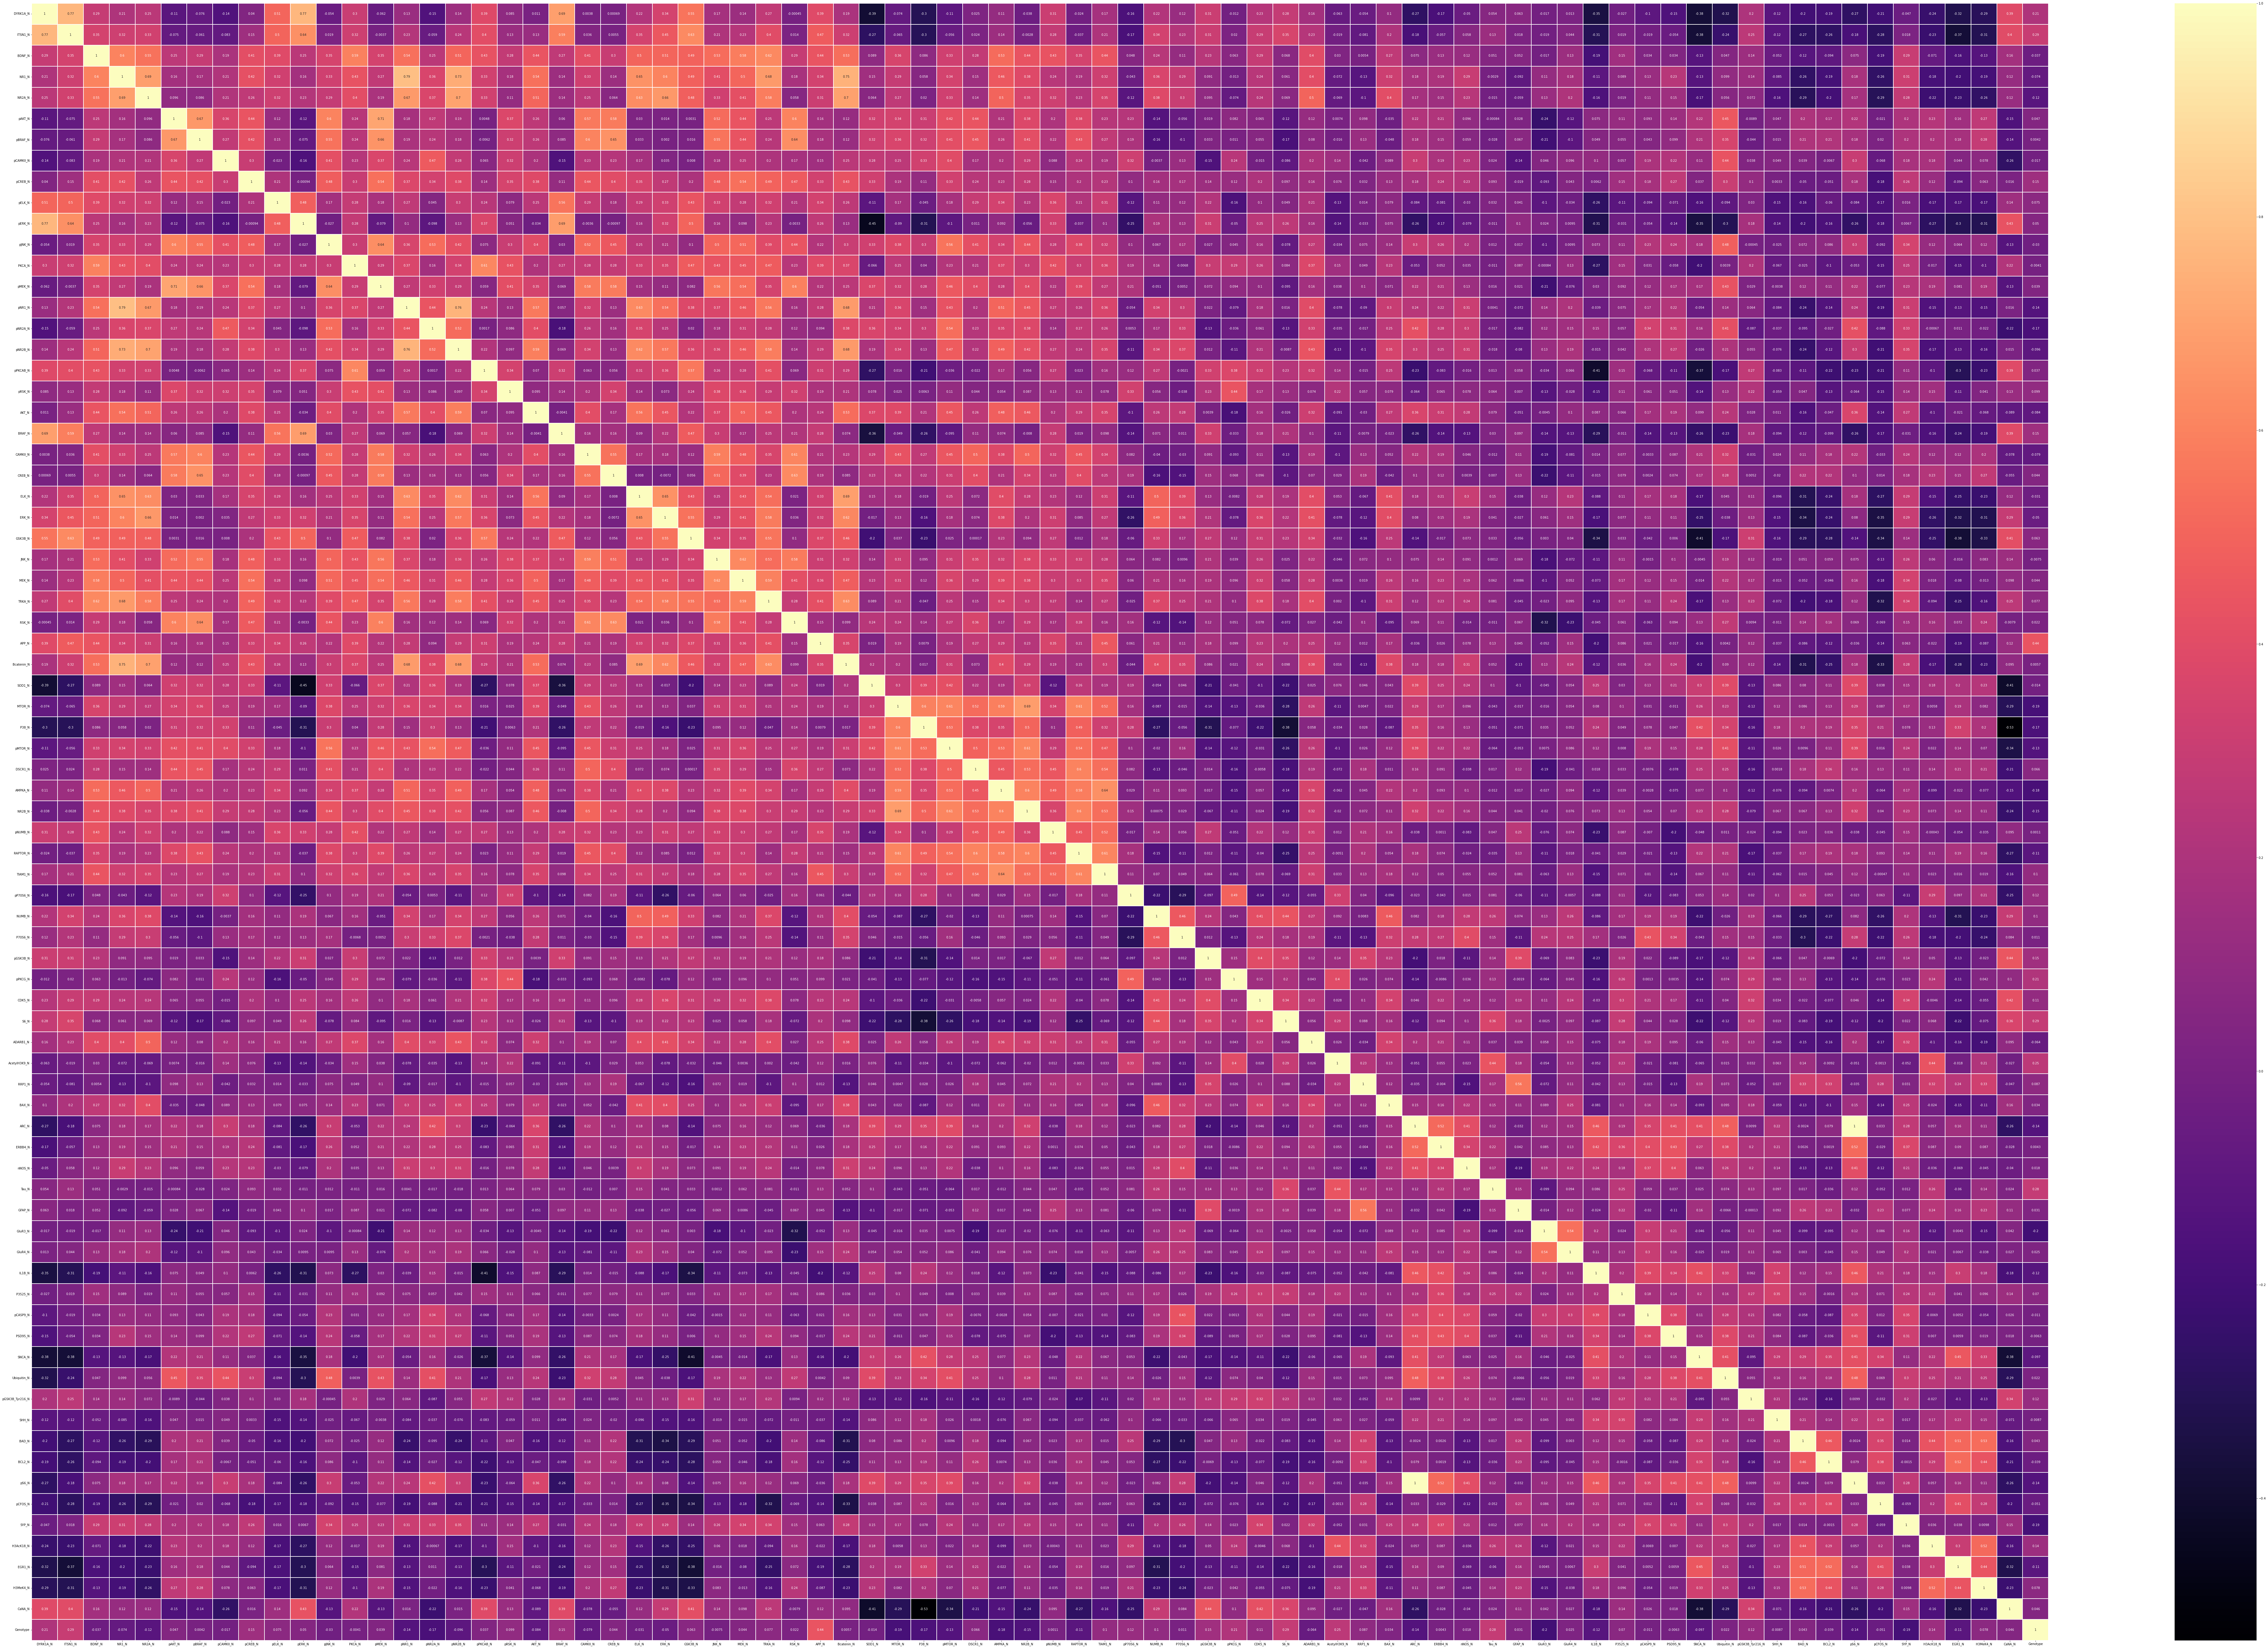

In [32]:
#METHOD 1 - Pearson Correlation
#Checking correlation between all the features beacuse multicollinearity can lead to an overfitted model and impricise parameter estimations
plt.figure(figsize = [150, 100], facecolor = 'white')
sns.heatmap(data.corr(method='kendall'), annot = True, linewidths = 2, cmap = "magma");

In [33]:
'''The following function can select highly correlated features, 
and will remove the first feature that is correlated with any other feature'''
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [34]:
#Drop the correlated features, that are correlated by more than 70%
correlated_features = correlation(x_train, 0.7)
print("Number of features that are found to be correlated with other feature by 70% of greater : ", len(set(correlated_features)))
print("List of the co-related features :- \n", correlated_features)

Number of features that are found to be correlated with other feature by 70% of greater :  35
List of the co-related features :- 
 {'AMPKA_N', 'ERK_N', 'Bcatenin_N', 'RSK_N', 'BRAF_N', 'PKCA_N', 'JNK_N', 'ELK_N', 'P38_N', 'pNR1_N', 'pPKCAB_N', 'pMEK_N', 'CREB_N', 'NR2B_N', 'pNUMB_N', 'ITSN1_N', 'pNR2B_N', 'NR1_N', 'Tau_N', 'pBRAF_N', 'TRKA_N', 'pERK_N', 'pS6_N', 'MEK_N', 'NR2A_N', 'NUMB_N', 'AKT_N', 'CAMKII_N', 'GSK3B_N', 'RAPTOR_N', 'DSCR1_N', 'pMTOR_N', 'pELK_N', 'pJNK_N', 'TIAM1_N'}


In [35]:
#Drop the correlated features from x_train & x_test dataset
x_train = x_train.drop(correlated_features, axis=1)
x_test = x_test.drop(correlated_features, axis=1)

In [36]:
x_train.shape, x_test.shape

((807, 42), (270, 42))

In [37]:
#Train the model & test in on all uncorrelared features (42 protiens)
all_function_call(x_train, y_train, x_test, y_test, "Kendall's correlation")


<<<Executing all ML models for 42 features>>>

Model Name : Support Vector Machines
Parameters : {'C': 10, 'kernel': 'rbf', 'probability': True}
Training Accuracy : 100.00%
Testing Accuracy : 99.63%
Cross Validation : 99.75%
Confusion Matrix : 

Classification Report: -
[[129   0]
 [  1 140]]


Model Name : Random Forest
Parameters : {'criterion': 'gini'}
Training Accuracy : 100.00%
Testing Accuracy : 95.56%
Cross Validation : 97.89%
Confusion Matrix : 

Classification Report: -
[[122   7]
 [  5 136]]


Model Name : XGBoost
Parameters : {}
Training Accuracy : 100.00%
Testing Accuracy : 95.56%
Cross Validation : 97.03%
Confusion Matrix : 

Classification Report: -
[[122   7]
 [  5 136]]


Model Name : Logistic Regression
Parameters : {'C': 1, 'max_iter': 1000}
Training Accuracy : 93.18%
Testing Accuracy : 90.37%
Cross Validation : 92.31%
Confusion Matrix : 

Classification Report: -
[[113  16]
 [ 10 131]]


Model Name : Decision Trees
Parameters : {'criterion': 'gini'}
Training Accurac

In [38]:
# #Forward feature selection for best out of 42 features
# #Train the model & test in on best features (42 protiens)
# best_features = forward_feature_selection(x_train, y_train, 42)
# all_function_call(x_train[best_features], y_train, x_test[best_features], y_test, "Forward Selection </42>")

In [39]:
# #Forward feature selection for best out of 30 features
# #Train the model & test in on best features (30 protiens)
# best_features = forward_feature_selection(x_train, y_train, 30)
# all_function_call(x_train[best_features], y_train, x_test[best_features], y_test, "Forward Selection </30>")

In [40]:
# #Forward feature selection for best out of 20 features
# #Train the model & test in on best features (20 protiens)
# best_features = forward_feature_selection(x_train, y_train, 20)
# all_function_call(x_train[best_features], y_train, x_test[best_features], y_test, "Forward Selection </20>")

In [41]:
# #Forward feature selection for best out of 15 features
# #Train the model & test in on best features (15 protiens)
# best_features = forward_feature_selection(x_train, y_train, 15)
# all_function_call(x_train[best_features], y_train, x_test[best_features], y_test, "Forward Selection </15>")

In [42]:
#Forward feature selection for best out of 10 features
#Train the model & test in on best features (10 protiens)
best_features = forward_feature_selection(x_train, y_train, 10)
all_function_call(x_train[best_features], y_train, x_test[best_features], y_test, "Forward Selection </10>")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:   26.8s finished

[2023-01-26 11:11:26] Features: 1/10 -- score: 0.6369907407407408[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  41 out of  41 | elapsed:   26.4s finished

[2023-01-26 11:11:52] Features: 2/10 -- score: 0.8624845679012345[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   24.2s finished

[2023-01-26 11:12:16] Features: 3/10 -- score: 0.894753086419753[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   

Best features <out of 12> :  10
Best feature names :  ['DYRK1A_N', 'BDNF_N', 'APP_N', 'pGSK3B_N', 'pPKCG_N', 'ADARB1_N', 'AcetylH3K9_N', 'nNOS_N', 'H3MeK4_N', 'CaNA_N']
Best features score :  0.9715432098765431

<<<Executing all ML models for 10 features>>>

Model Name : Support Vector Machines
Parameters : {'C': 10, 'kernel': 'rbf', 'probability': True}
Training Accuracy : 98.51%
Testing Accuracy : 95.19%
Cross Validation : 97.65%
Confusion Matrix : 

Classification Report: -
[[121   8]
 [  5 136]]


Model Name : Random Forest
Parameters : {'criterion': 'gini'}
Training Accuracy : 100.00%
Testing Accuracy : 95.19%
Cross Validation : 96.53%
Confusion Matrix : 

Classification Report: -
[[121   8]
 [  5 136]]


Model Name : XGBoost
Parameters : {}
Training Accuracy : 100.00%
Testing Accuracy : 95.56%
Cross Validation : 96.04%
Confusion Matrix : 

Classification Report: -
[[124   5]
 [  7 134]]


Model Name : Decision Trees
Parameters : {'criterion': 'gini'}
Training Accuracy : 100.00%
T

In [43]:
#Using ANOVA feature selection
fvalue_Best = SelectKBest(f_classif, k=20)
x_train_anova = pd.DataFrame(fvalue_Best.fit_transform(x_train, y_train))
x_test_nova = pd.DataFrame(fvalue_Best.fit_transform(x_test, y_test))
all_function_call(x_train_anova, y_train, x_test_nova, y_test, "ANOVA")


<<<Executing all ML models for 20 features>>>



/Users/arpit/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arpit/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arpit/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arpit/opt/an

Model Name : Support Vector Machines
Parameters : {'C': 10, 'kernel': 'rbf', 'probability': True}
Training Accuracy : 100.00%
Testing Accuracy : 52.22%
Cross Validation : 98.64%
Confusion Matrix : 

Classification Report: -
[[  0 129]
 [  0 141]]


Model Name : XGBoost
Parameters : {}
Training Accuracy : 100.00%
Testing Accuracy : 35.56%
Cross Validation : 96.41%
Confusion Matrix : 

Classification Report: -
[[ 92  37]
 [137   4]]


Model Name : Random Forest
Parameters : {'criterion': 'gini'}
Training Accuracy : 100.00%
Testing Accuracy : 45.56%
Cross Validation : 95.67%
Confusion Matrix : 

Classification Report: -
[[114  15]
 [132   9]]


Model Name : K-Neatest Neighbors
Parameters : {'n_neighbors': 20}
Training Accuracy : 93.68%
Testing Accuracy : 47.41%
Cross Validation : 88.97%
Confusion Matrix : 

Classification Report: -
[[109  20]
 [122  19]]


Model Name : Decision Trees
Parameters : {'criterion': 'gini'}
Training Accuracy : 100.00%
Testing Accuracy : 52.22%
Cross Validation 

In [44]:
#Using ANOVA feature selection
fvalue_Best = SelectKBest(f_classif, k=15)
x_train_anova = pd.DataFrame(fvalue_Best.fit_transform(x_train, y_train))
x_test_nova = pd.DataFrame(fvalue_Best.fit_transform(x_test, y_test))
all_function_call(x_train_anova, y_train, x_test_nova, y_test, "ANOVA")


<<<Executing all ML models for 15 features>>>



/Users/arpit/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arpit/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arpit/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model Name : Support Vector Machines
Parameters : {'C': 10, 'kernel': 'rbf', 'probability': True}
Training Accuracy : 99.88%
Testing Accuracy : 51.48%
Cross Validation : 97.40%
Confusion Matrix : 

Classification Report: -
[[  0 129]
 [  2 139]]


Model Name : Random Forest
Parameters : {'criterion': 'gini'}
Training Accuracy : 100.00%
Testing Accuracy : 42.96%
Cross Validation : 95.54%
Confusion Matrix : 

Classification Report: -
[[74 55]
 [99 42]]


Model Name : XGBoost
Parameters : {}
Training Accuracy : 100.00%
Testing Accuracy : 37.78%
Cross Validation : 94.55%
Confusion Matrix : 

Classification Report: -
[[ 98  31]
 [137   4]]


Model Name : K-Neatest Neighbors
Parameters : {'n_neighbors': 20}
Training Accuracy : 92.57%
Testing Accuracy : 40.37%
Cross Validation : 89.96%
Confusion Matrix : 

Classification Report: -
[[ 89  40]
 [121  20]]


Model Name : Decision Trees
Parameters : {'criterion': 'gini'}
Training Accuracy : 100.00%
Testing Accuracy : 41.48%
Cross Validation : 86.

In [45]:
#Using ANOVA feature selection
fvalue_Best = SelectKBest(f_classif, k=10)
x_train_anova = pd.DataFrame(fvalue_Best.fit_transform(x_train, y_train))
x_test_nova = pd.DataFrame(fvalue_Best.fit_transform(x_test, y_test))
all_function_call(x_train_anova, y_train, x_test_nova, y_test, "ANOVA")


<<<Executing all ML models for 10 features>>>



/Users/arpit/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arpit/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arpit/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model Name : Support Vector Machines
Parameters : {'C': 10, 'kernel': 'rbf', 'probability': True}
Training Accuracy : 98.76%
Testing Accuracy : 52.22%
Cross Validation : 96.90%
Confusion Matrix : 

Classification Report: -
[[  0 129]
 [  0 141]]


Model Name : Random Forest
Parameters : {'criterion': 'gini'}
Training Accuracy : 100.00%
Testing Accuracy : 78.89%
Cross Validation : 95.05%
Confusion Matrix : 

Classification Report: -
[[106  23]
 [ 34 107]]


Model Name : XGBoost
Parameters : {}
Training Accuracy : 100.00%
Testing Accuracy : 78.89%
Cross Validation : 94.68%
Confusion Matrix : 

Classification Report: -
[[104  25]
 [ 32 109]]


Model Name : K-Neatest Neighbors
Parameters : {'n_neighbors': 20}
Training Accuracy : 93.56%
Testing Accuracy : 55.93%
Cross Validation : 91.08%
Confusion Matrix : 

Classification Report: -
[[104  25]
 [ 94  47]]


Model Name : Decision Trees
Parameters : {'criterion': 'gini'}
Training Accuracy : 100.00%
Testing Accuracy : 51.85%
Cross Validation :

In [46]:
result_df = pd.DataFrame(main_result_dict, index=feature_size_list)
result_df = result_df.sort_values('Feature Size', ascending=False)
result_df.index.name = 'Feature Selection Method'
result_df.drop(labels=[], inplace=True, axis=1)
result_df

,Feature Size,Logistic Regression,Decision Trees,Random Forest,K-Neatest Neighbors,Support Vector Machines,XGBoost
Feature Selection Method,,,,,,,
No feature selection,77,96.28% | 94.67% | 0.978,100.00% | 90.10% | 0.900,100.00% | 98.64% | 0.999,92.44% | 89.09% | 0.970,99.88% | 99.88% | 0.999,100.00% | 97.90% | 0.991
Kendall's correlation,42,93.18% | 92.31% | 0.958,100.00% | 89.47% | 0.855,100.00% | 97.89% | 0.995,91.70% | 88.35% | 0.960,100.00% | 99.75% | 0.999,100.00% | 97.03% | 0.988
ANOVA,20,88.35% | 87.11% | 0.344,100.00% | 88.84% | 0.500,100.00% | 95.67% | 0.422,93.68% | 88.97% | 0.595,100.00% | 98.64% | 0.345,100.00% | 96.41% | 0.270
ANOVA,15,86.99% | 86.49% | 0.442,100.00% | 86.87% | 0.425,100.00% | 95.54% | 0.448,92.57% | 89.96% | 0.515,99.88% | 97.40% | 0.498,100.00% | 94.55% | 0.305
Forward Selection </10>,10,87.36% | 86.24% | 0.915,100.00% | 90.96% | 0.894,100.00% | 96.53% | 0.984,93.93% | 89.46% | 0.963,98.51% | 97.65% | 0.979,100.00% | 96.04% | 0.979
ANOVA,10,84.76% | 84.38% | 0.881,100.00% | 87.12% | 0.511,100.00% | 95.05% | 0.857,93.56% | 91.08% | 0.716,98.76% | 96.90% | 0.684,100.00% | 94.68% | 0.880


In [47]:
# result_df.to_csv("./Datasets/Data_Cortex_Nuclear_Results.csv", index=True)

In [48]:
#New Dataset
best_features = ['DYRK1A_N', 'BDNF_N', 'APP_N', 'MTOR_N', 'pGSK3B_N', 
                 'pPKCG_N', 'AcetylH3K9_N', 'IL1B_N', 'pGSK3B_Tyr216_N', 'CaNA_N']
best_x_train, best_x_test = x_train[best_features], x_test[best_features]


<<<Executing all ML models for 10 features>>>

Model Name : Random Forest
Parameters : {'criterion': 'gini'}
Training Accuracy : 100.00%
Testing Accuracy : 94.81%
Cross Validation : 95.92%
Confusion Matrix : 

Classification Report: -
[[122   7]
 [  7 134]]


Model Name : Support Vector Machines
Parameters : {'C': 10, 'kernel': 'rbf', 'probability': True}
Training Accuracy : 97.40%
Testing Accuracy : 93.33%
Cross Validation : 95.67%
Confusion Matrix : 

Classification Report: -
[[121   8]
 [ 10 131]]


Model Name : XGBoost
Parameters : {}
Training Accuracy : 100.00%
Testing Accuracy : 96.30%
Cross Validation : 95.54%
Confusion Matrix : 

Classification Report: -
[[124   5]
 [  5 136]]


Model Name : K-Neatest Neighbors
Parameters : {'n_neighbors': 20}
Training Accuracy : 93.93%
Testing Accuracy : 89.26%
Cross Validation : 91.70%
Confusion Matrix : 

Classification Report: -
[[109  20]
 [  9 132]]


Model Name : Decision Trees
Parameters : {'criterion': 'gini'}
Training Accuracy : 100.

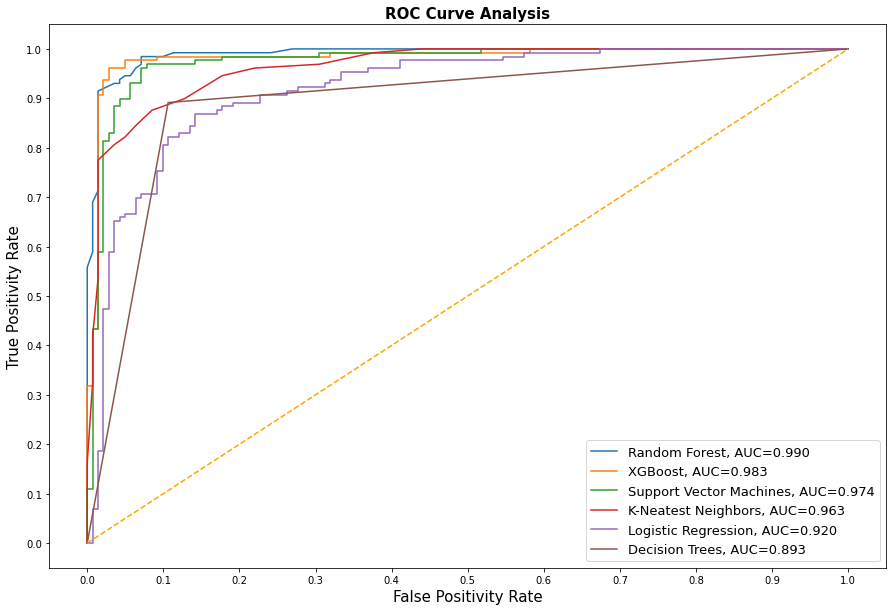


Feature size list :  ['No feature selection', "Kendall's correlation", 'Forward Selection </10>', 'ANOVA', 'ANOVA', 'ANOVA', '10 Best Features']

Main result dict :  {'Feature Size': [77, 42, 10, 20, 15, 10, 10], 'Logistic Regression': ['96.28% | 94.67% | 0.978', '93.18% | 92.31% | 0.958', '87.36% | 86.24% | 0.915', '88.35% | 87.11% | 0.344', '86.99% | 86.49% | 0.442', '84.76% | 84.38% | 0.881', '89.59% | 88.10% | 0.920'], 'Decision Trees': ['100.00% | 90.10% | 0.900', '100.00% | 89.47% | 0.855', '100.00% | 90.96% | 0.894', '100.00% | 88.84% | 0.500', '100.00% | 86.87% | 0.425', '100.00% | 87.12% | 0.511', '100.00% | 90.72% | 0.893'], 'Random Forest': ['100.00% | 98.64% | 0.999', '100.00% | 97.89% | 0.995', '100.00% | 96.53% | 0.984', '100.00% | 95.67% | 0.422', '100.00% | 95.54% | 0.448', '100.00% | 95.05% | 0.857', '100.00% | 95.92% | 0.990'], 'K-Neatest Neighbors': ['92.44% | 89.09% | 0.970', '91.70% | 88.35% | 0.960', '93.93% | 89.46% | 0.963', '93.68% | 88.97% | 0.595', '92.57% |

In [49]:
#Results of all models with the new dataset
all_function_call(best_x_train, y_train, best_x_test, y_test, "10 Best Features")

In [50]:
def decision_tree_pruning(best_x_train, y_train, best_x_test, y_test):
    
    #Calculate train, test scores w.r.t the cost variable alpha
        
    model = DecisionTreeClassifier(random_state=0).fit(best_x_train, y_train)
    
    #For roc-auc curve
    yproba = model.predict_proba(best_x_test)[::, 1]
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    #For classification report
    y_pred_test = model.predict(best_x_test)
    report = classification_report(y_test, y_pred_test, target_names=['Control', 'Ts65Dn'])
    
    path = model.cost_complexity_pruning_path(best_x_train, y_train)
    ccp_alphas, impurities = path.ccp_alphas, path.impurities
    
    train_scores, test_scores  = [], []
    for alpha in ccp_alphas:
        model = DecisionTreeClassifier(random_state=0, ccp_alpha=alpha)
        model.fit(best_x_train, y_train)
        train_scores.append(model.score(best_x_train, y_train))
        test_scores.append(model.score(best_x_test, y_test))
    
    fig, ax = plt.subplots()
    ax.set_xlabel("alpha")
    ax.set_ylabel("accuracy")
    ax.set_title("Accuracy vs alpha for training and testing sets")
    ax.plot(ccp_alphas, train_scores, marker='o', label="train",
            drawstyle="steps-post")
    ax.plot(ccp_alphas, test_scores, marker='o', label="test",
            drawstyle="steps-post")
    ax.legend()
    plt.show()
    
    return fpr, tpr, auc, report

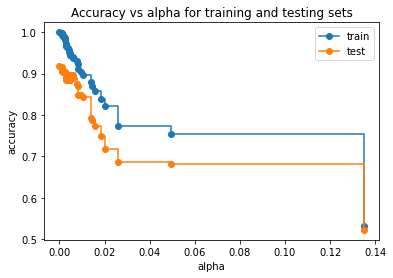

In [51]:
b_fpr, b_tpr, b_auc, b_report = decision_tree_pruning(best_x_train, y_train, best_x_test, y_test)

In [52]:
best_alpha_value = 0.0084
model = DecisionTreeClassifier(random_state=0, ccp_alpha=best_alpha_value).fit(best_x_train, y_train)

#For roc-auc curve
yproba = model.predict_proba(best_x_test)[::, 1]
a_fpr, a_tpr, _ = roc_curve(y_test,  yproba)
a_auc = roc_auc_score(y_test, yproba)

#For classification report
y_pred_test = model.predict(best_x_test)
a_report = classification_report(y_test, y_pred_test, target_names=['Control', 'Ts65Dn'])

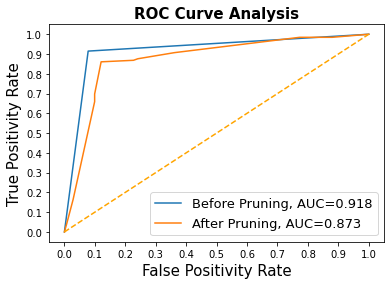

In [53]:
fig = plt.figure()
plt.plot(b_fpr, b_tpr, label="{}, AUC={:.3f}".format("Before Pruning", b_auc))
plt.plot(a_fpr, a_tpr, label="{}, AUC={:.3f}".format("After Pruning", a_auc))
plt.plot([0,1], [0,1], color='orange', linestyle='--')
plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positivity Rate", fontsize=15)
plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positivity Rate", fontsize=15)
plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')
plt.show()

In [54]:
print("Before pruning classification report : \n", b_report, "\n\n")
print("After pruning classificationn  report : \n", a_report, "\n\n")

Before pruning classification report : 
               precision    recall  f1-score   support

     Control       0.92      0.92      0.92       141
      Ts65Dn       0.91      0.91      0.91       129

    accuracy                           0.92       270
   macro avg       0.92      0.92      0.92       270
weighted avg       0.92      0.92      0.92       270
 


After pruning classification report : 
               precision    recall  f1-score   support

     Control       0.87      0.88      0.88       141
      Ts65Dn       0.87      0.86      0.86       129

    accuracy                           0.87       270
   macro avg       0.87      0.87      0.87       270
weighted avg       0.87      0.87      0.87       270
 


